In [5]:
!pip install -r requirements.txt

     |████████████████████████████████| 394.3 MB 6.7 kB/s  eta 0:00:01
     |████████████████████████████████| 10.6 MB 52.7 MB/s eta 0:00:01
     |████████████████████████████████| 462 kB 52.2 MB/s eta 0:00:01
     |████████████████████████████████| 129 kB 73.4 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 74 kB/s s eta 0:00:01
     |████████████████████████████████| 65 kB 914 kB/s  eta 0:00:01
     |████████████████████████████████| 3.8 MB 65.8 MB/s eta 0:00:01
     |████████████████████████████████| 2.9 MB 64.4 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 1.9 MB/s  eta 0:00:01
     |████████████████████████████████| 781 kB 65.6 MB/s eta 0:00:01


     |████████████████████████████████| 147 kB 71.8 MB/s eta 0:00:01
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4829 sha256=a636db480d2f37a9d3a643bb79dcdd66477712769848a042c484ad6117dce3ca
  Stored in directory: /home/ec2-user/.cache/pip/wheels/93/2a/eb/e58dbcbc963549ee4f065ff80a59f274cc7210b6eab962acdc
Successfully built termcolor
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.35.0
    Uninstalling grpcio-1.35.0:
      Successfully uninstalled grpcio-1.35.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


# Disaster tweets classifier

Explanation of project goal -> analyze tweets classifying them into disaster and non-disaster ones to extract useful information during crises

In [6]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
plt.style.use('ggplot')
import re
import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import defaultdict
from collections import  Counter
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import (LSTM, 
                          Embedding, 
                          BatchNormalization,
                          Dense, 
                          TimeDistributed, 
                          Dropout, 
                          Bidirectional,
                          Flatten, 
                          GlobalMaxPool1D)
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report,
    accuracy_score
)

## 1. EDA

### 1.1 Read train and test datasets

In [49]:
train = pd.read_csv('./input/tweets_data/train.csv')
test = pd.read_csv('./input/tweets_data/test.csv')

train.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### 1.2 Get the total number of samples in both datasets

In [50]:
train_total_rows = train.shape[0]
test_total_rows = test.shape[0]

print(f"Total number of train samples = {train_total_rows} \n\
Total number of test samples = {test_total_rows}")

Total number of train samples = 7613 
Total number of test samples = 3263


### 1.3 Checking class distribution

Total number of disaster samples (1) = 3271 
Total number of non disaster samples (0) = 4342


Text(0, 0.5, 'train tweets')

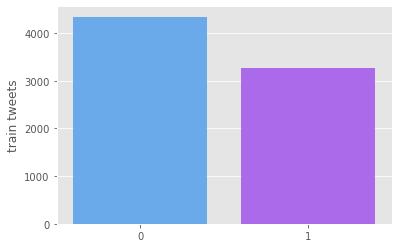

In [51]:
x = train.target.value_counts()
print(f"Total number of disaster samples (1) = {x[1]} \n\
Total number of non disaster samples (0) = {x[0]}")

sns.barplot(x.index, x, palette='cool')
plt.gca().set_ylabel('train tweets')

### 1.4 Get number of characters in tweets

Text(0.5, 0.98, '# Characters in tweets')

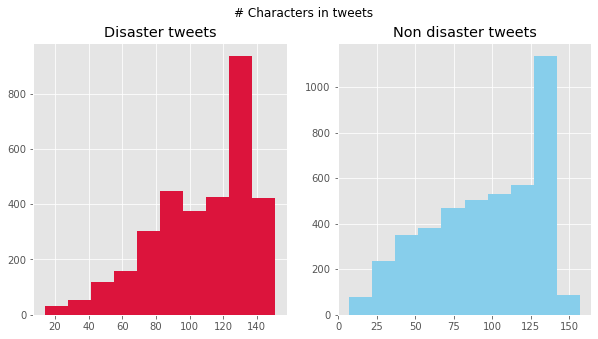

In [52]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
tweet_len = train[train['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='crimson')
ax1.set_title('Disaster tweets')
tweet_len = train[train['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='skyblue')
ax2.set_title('Non disaster tweets')
fig.suptitle('# Characters in tweets')

### 1.5 Get number of words in each tweet

Text(0.5, 0.98, 'Words in a tweet')

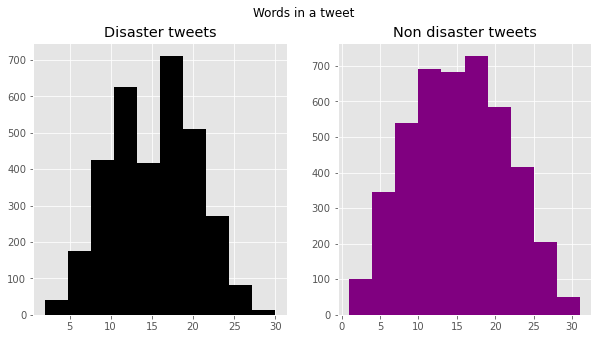

In [53]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
tweet_len = train[train['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len, color='black')
ax1.set_title('Disaster tweets')
tweet_len = train[train['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='purple')
ax2.set_title('Non disaster tweets')
fig.suptitle('Words in a tweet')

### 1.6 Calculate the average word length in each tweet

Text(0.5, 0.98, 'Average word length in each tweet')

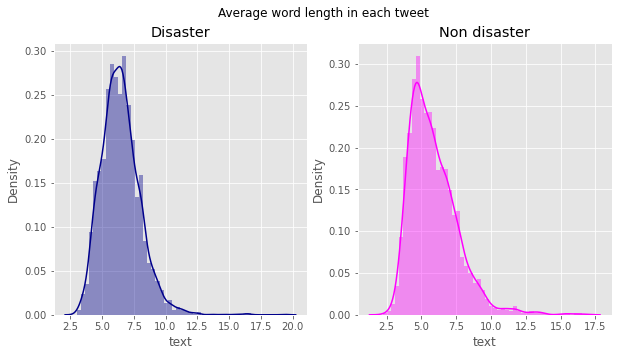

In [54]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word = train[train['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='darkblue')
ax1.set_title('Disaster')
word = train[train['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='magenta')
ax2.set_title('Non disaster')
fig.suptitle('Average word length in each tweet')

### 1.7 Create a corpus function

In [44]:
def create_corpus_df(df, target):
    """
        Create a corpus from a give df for a target class
        
        df: Pandas dataframe
        target: class identifier
    """
    
    corpus=[]
    for x in df[df['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

### 1.8 Analize punctuations marks in non-disaster class (0)

<BarContainer object of 20 artists>

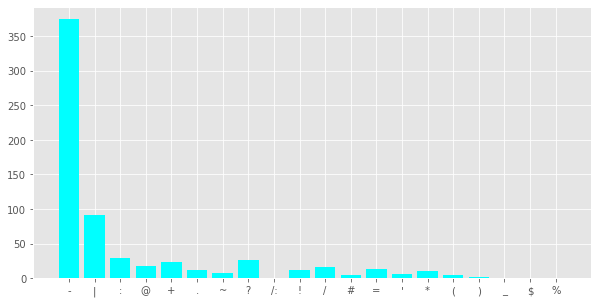

In [45]:
plt.figure(figsize=(10,5))
corpus = create_corpus_df(train, 0)
dic = defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
x,y=zip(*dic.items())
plt.bar(x, y,color='cyan')

### 1.9 Analize punctuations marks in disaster class (1)

<BarContainer object of 18 artists>

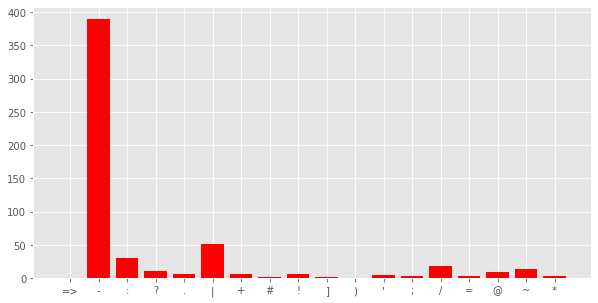

In [46]:
plt.figure(figsize=(10,5))
corpus = create_corpus_df(train, 1)
dic = defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
x,y = zip(*dic.items())
plt.bar(x, y, color='red')

## 2. Preprocessing

### 2.1 Download stopwords

In [60]:
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 2.2 Get the most common words

<AxesSubplot:>

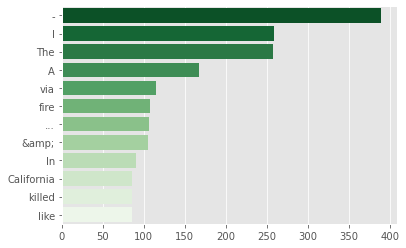

In [62]:
counter = Counter(corpus)
most = counter.most_common()
x=[]
y=[]
for word, count in most[:40]:
    if (word not in stopwords) :
        x.append(word)
        y.append(count)
sns.barplot(x=y, y=x, palette='Greens_r')

### 2.3 Bigram analysis

<AxesSubplot:>

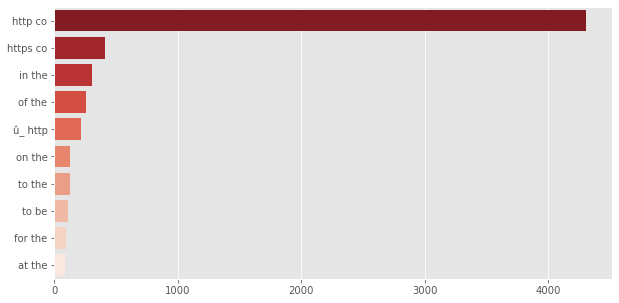

In [63]:
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
plt.figure(figsize=(10,5))
top_tweet_bigrams = get_top_tweet_bigrams(tweet['text'])[:10]
x,y = map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x, palette='Reds_r')

### 2.4 Renaming location names

<AxesSubplot:xlabel='location'>

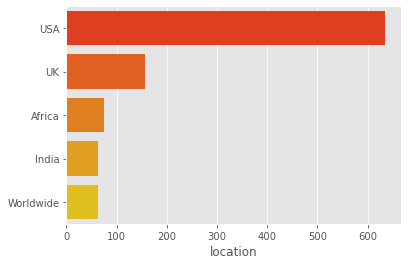

In [64]:
df = pd.concat([tweet,test])
df['location'].replace({'United States':'USA',
                           'New York':'USA',
                            "London":'UK',
                            "Los Angeles, CA":'USA',
                            "Washington, D.C.":'USA',
                            "California":'USA',
                             "Chicago, IL":'USA',
                             "Chicago":'USA',
                            "New York, NY":'USA',
                            "California, USA":'USA',
                            "FLorida":'USA',
                            "Nigeria":'Africa',
                            "Kenya":'Africa',
                            "Everywhere":'Worldwide',
                            "San Francisco":'USA',
                            "Florida":'USA',
                            "United Kingdom":'UK',
                            "Los Angeles":'USA',
                            "Toronto":'Canada',
                            "San Francisco, CA":'USA',
                            "NYC":'USA',
                            "Seattle":'USA',
                            "Earth":'Worldwide',
                            "Ireland":'UK',
                            "London, England":'UK',
                            "New York City":'USA',
                            "Texas":'USA',
                            "London, UK":'UK',
                            "Atlanta, GA":'USA',
                            "Mumbai":"India"},inplace=True)
sns.barplot(y = df['location'].value_counts()[:5].index, x = df['location'].value_counts()[:5],
            palette='autumn', orient='h')

## 3. Data cleaning

In [65]:
def clean_text(text):
    """
        Make text lowercase, remove text in square brackets,remove links,remove punctuation
        and remove words containing numbers.
    """
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

### 3.1 Applying the cleaning function to both test and training datasets

In [66]:
df['text'] = df['text'].apply(lambda x: clean_text(x))
df['text'].head()

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3     people receive wildfires evacuation orders in...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

### 3.2 Removing emojis

In [67]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

df['text']=df['text'].apply(lambda x: remove_emoji(x))